In [42]:
import tweepy
import pymongo
import nltk
import matplotlib.pyplot as plt
import pandas as pd

from pymongo import MongoClient
# nltk.download('stopwords')
from nltk.corpus import stopwords          # Help remove stop-words like ['a', 'the', 'and' ..]
# nltk.download('punkt')
from nltk.tokenize import word_tokenize    # Help tokenize sentences

from wordcloud import WordCloud 


# Secret keys
CONSUMER_KEY = 'rtOHXdgu2S8SIFctVfF0yhXcY'
CONSUMER_SECRET = 'l8E5AIArXxZvr2idFTCzoLDkjqssLVIeo3TaUSyObqH0tQ7KsE'

# login to Twitter with extended rate limiting
# must be used with the Tweepy Cursor to wrap the search and enact the waits
def appauth_login():
    # get the authorization from Twitter and save in the Tweepy package
    auth = tweepy.AppAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    # apparently no need to set the other access tokens
    tweepy_api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # if a null api is returned, give error message
    if (not tweepy_api):
        print("Problem Connecting to API with AppAuth")

    # return the Twitter api object that allows access for the Tweepy api functions
    return tweepy_api

api = appauth_login()

print("Twitter AppAuthorization: ", api)

Twitter AppAuthorization:  <tweepy.api.API object at 0x7f89e10c40a0>


In [32]:
# Fetch tweets based on a query, here we will use '#covid'
query = '#covid'
max_results = 5000

# Use the tweepy to fetch tweets from tweeter
search_results = [status for status in tweepy.Cursor(api.search, q=query).items(max_results)]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
tweets = [res._json for res in search_results]

# Connect to a mongo-db instance, create a db/collection

client = MongoClient('localhost', 27017)

# Create a db
db = client.hw2

# Drop a collection
for collection in db.list_collection_names():
    if 'tweet_info' == collection:
        print('Found collection {0}. Removing it!'.format(collection))
        db.tweet_info.drop()

# Create a collection/table
hw2_collection = db.tweet_info

# Use the structure below to put tweets into Mongo-DB
# Time, Tweet, User, Retweeted, Retweet-count
tweet_docs = []
for tweet in tweets:
    tweet_docs.append({'time': tweet['created_at'], 
                       'tweet': tweet['text'],
                       'user': tweet['user']['name'], 
                       'retweeted': tweet['retweeted'], 
                       'retweet_count': tweet['retweet_count']})
print(tweet_docs[:10]) 

Found collection tweet_info. Removing it!
[{'time': 'Mon Nov 23 01:41:50 +0000 2020', 'tweet': 'I sure hope I don’t get #COVID https://t.co/pM5MCfazdC', 'user': 'Kim Fulton', 'retweeted': False, 'retweet_count': 0}, {'time': 'Mon Nov 23 01:41:50 +0000 2020', 'tweet': 'RT @davidmweissman: If your son got #COVID, would you go golfing?', 'user': 'Kelleymangold', 'retweeted': False, 'retweet_count': 2786}, {'time': 'Mon Nov 23 01:41:47 +0000 2020', 'tweet': 'RT @nolaforensix: It’s not funny that “We will not comply” rhymes with “Better we should all die”. W(here)TF did all this #stupid come from…', 'user': 'Katherine Hosch', 'retweeted': False, 'retweet_count': 1}, {'time': 'Mon Nov 23 01:41:42 +0000 2020', 'tweet': 'RT @Factsmatter2: The state of free speech in the UK ⬇️ at the heart of the Commonwealth @ComSecYouth @JCommwlthLaw \n\nJournalist Julian #As…', 'user': 'Simon Hunt', 'retweeted': False, 'retweet_count': 3}, {'time': 'Mon Nov 23 01:41:37 +0000 2020', 'tweet': 'RT @DarshaPhilip

In [34]:
# Insert into Mongo-DB
hw2_collection.insert_many(tweet_docs)

In [39]:
# Check if data is present in Mongo-DB
docs = hw2_collection.find()
print('Number of documents: {0}'.format(docs.count()))

Number of documents: 5000


<ipython-input-39-4559ad899924>:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  print('Number of documents: {0}'.format(docs.count()))


In [36]:
# Pre-processsing/clean-up of tweets to plot a wordcloud
# Use the NLTK package to clean-up stop-words, punctuation marks etc.

all_words = []
fil_words = []

# Initialize punctuations 
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''

# Create a stop_words list for English, Spanish etc.
stop_words = stopwords.words('english')
stop_words.append(stopwords.words('spanish'))

# Add custom filters
stop_words.extend(['https', 'rt', 'covid', 'covid19', 'covid-19', '\'ve', '\'nt', 'n\'t', 
                   'many', 'de', 'la'])

for doc in docs:
    orig_sentence = doc['tweet']
    word_tokens = word_tokenize(orig_sentence)
    fil_sentence_1 = [w for w in word_tokens if w.isascii()]
    # Filter sentence based on stop_words
    fil_sentence_2 = [w for w in fil_sentence_1 if not w.lower() in stop_words]
    # Filter sentence based on punctuations
    fil_sentence_final = [w for w in fil_sentence_2 if not w in punc]
    all_words.extend(word_tokens)
    fil_words.extend(fil_sentence_final)
    
# Finally, walk and remove any word containing the link '//t.co'
for word in fil_words:
    if 't.co' in word:
        fil_words.remove(word)

print('Orig-words: {0} vs Filtered-words: {1} ({2}% reduction)'.format(len(all_words), 
                                                                       len(fil_words), 
                                                                       (len(all_words)-len(fil_words)) * 100 /len(all_words)))

Orig-words: 130377 vs Filtered-words: 54920 (57.87600573720825% reduction)


In [26]:
fil_words_str = '' # For wordcloud we need the words to be in a str format

for word in fil_words:
    fil_words_str += word + " "

# print(fil_words)
print(fil_words_str)

SwissEmbassyIr cope health effects Switzerland support 1 000 vulnerable households thatalicewu note abroad Realizing 5 days US folks back home realize 8/ 's 3 hours without call back know someone SanDiego unsheltered medical Avete vinto ragazzi vanno casa Torino COVID19italia LukaszukAB jkenney remember JustinTrudeau quarantining hide held press conferences every day front francemusique contemporaine au temps du Camille Matthias Pintscher Francesco Filidei Yann Robin Minhvi_Oficial AHORA || Pdte NicolasMaduro Venezuela pido conciencia disciplina para tener unas NavidadesFelices en AmorporValpo Hola cta AmorporValpo sigue en pausa otra semana al menos hospitalizado Al se agrega neumonitis Vaccineringen kan redan om veckor USA covid_19 Corona coronakrisen Acertamos el regalo publicado ayer los locales sin 5 titulares con su central Begic con fiebre negativo wqbelle Editorial cartoon Signe Wilkinson BarackObama Barack Obama Biden Biden2020 ByeDon ByeDon2020 JoeBiden NickTorfaen LucyMPowel

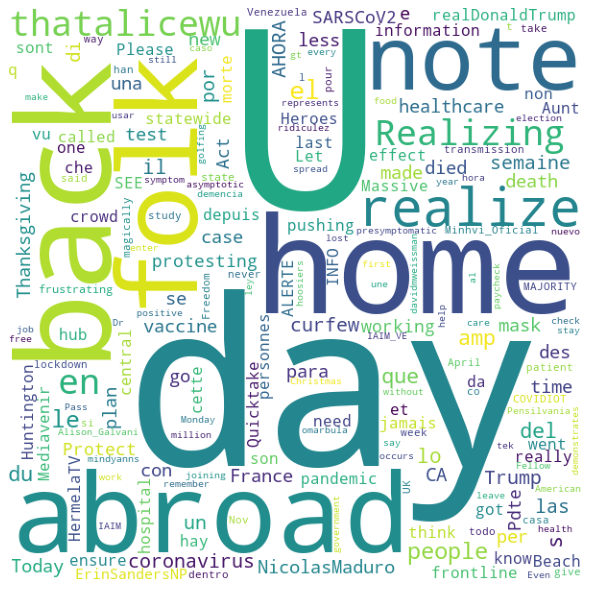

In [37]:
# Plot a wordcloud
wordcloud = WordCloud(width = 600, height = 600, 
                      background_color ='white', 
                      min_font_size = 10,
                      collocations = False).generate(fil_words_str)

# See word frequencies
# print(wordcloud.words_)

# NOTE:
# WordCloud library has a peculiar way of drawing up frequencies by grouping common words. 
# Workaround - Use the 'collocations = False' as seen above.

# Using matplotlib plt visualize the wordcloud                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Inferences from word cloud:
# - The trending topic seems to be around a topic originated by user 'thatalicewu':
# " A note from abroad: Realizing now that I've been 5 days out of US that 
#   many folks back home don't realize how other countr…""
# - Correspondingly, we see words: days, back, abroad, note, U(for USA) etc. as high frequency words

In [119]:
# Analysis on Twitter data
#  - Let's load the data from Mongo-db into a Pandas dataframe

# Fetch all Mongo-db records
docs = hw2_collection.find()

# Walk the records and translate to a dict()
time = []
user = []
retweeted = []
count = []
tweet = []

for doc in docs:
    time.append(doc['time'])
    user.append(doc['user'])
    tweet.append(doc['tweet'])
    retweeted.append(doc['retweeted']) 
    count.append(doc['retweet_count']) 
    
twitter_dict = {'Time': time, 'User': user, 'Tweet': tweet, 'Retweeted': retweeted, 
                'Retweet_Count': count}

# Create a pandas data-frame
df = pd.DataFrame(twitter_dict)

# Determine time-range of tweets
print('Most recent tweets: \n {0}'.format(df['Time'].head(1)[0]))
print('Oldest tweets: \n {0}'.format(df['Time'].tail(1)[max_results - 1])) 

# The window of tweets is between Nov-22 22:24:31 to Nov-23 01:41:50

# Find the topic that's most re-tweeted/RT'ed
df[df['Retweet_Count'] == df['Retweet_Count'].max()]

Most recent tweets: 
 Mon Nov 23 01:41:50 +0000 2020
Oldest tweets: 
 Sun Nov 22 22:24:31 +0000 2020


,Time,User,Tweet,Retweeted,Retweet_Count
4957,Sun Nov 22 22:25:39 +0000 2020,AleTheExpat,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4969,Sun Nov 22 22:25:18 +0000 2020,ʀ ᴀ ɪ ɴ,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4972,Sun Nov 22 22:25:13 +0000 2020,Elizabeth Feifer,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4985,Sun Nov 22 22:24:47 +0000 2020,NATL SIGNAL BOOST FOR BLUE GA SENATE RACES - #FBR,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4987,Sun Nov 22 22:24:46 +0000 2020,Harriett Robinson,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4988,Sun Nov 22 22:24:45 +0000 2020,Alanna Boudreau,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4993,Sun Nov 22 22:24:39 +0000 2020,Cathipat😷Persist,RT @thatalicewu: A note from abroad: Realizing...,False,11845
4995,Sun Nov 22 22:24:38 +0000 2020,"The CBDiva, from 6’ away.",RT @thatalicewu: A note from abroad: Realizing...,False,11845


In [127]:
import operator

# Find most active user in the time window
active_users = {}

# Fetch all Mongo-db records
docs = hw2_collection.find()

for doc in docs:
    if doc['user'] in active_users:
        active_users[doc['user']] += 1
    else:
        active_users[doc['user']] = 1

sorted_active_users = max(active_users.items(), key=operator.itemgetter(1))
print('Most tweets by: {0} (count = {1})'.format(sorted_active_users[0], sorted_active_users[1]))

Most tweets by: All Express News (count = 67)
